In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/chicago-divvy-bicycle-sharing-data/data.csv
/kaggle/input/chicago-divvy-bicycle-sharing-data/data_raw.csv


In [2]:
# Import libraries for data manipulation
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import seaborn as sns

# Import library for modeling
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [3]:
# Read in csv file
df_in = pd.read_csv('/kaggle/input/chicago-divvy-bicycle-sharing-data/data.csv')

In [41]:
df = df_in.sample(n=300000)

First of all, we add some new features: holiday, weekend, season and some interaction categorical variables. Then we will generate 2 new dataframe to analysis. One is dataframe at hour level while the other is dataframe at day level. 

In [42]:
import itertools

desc = df.describe()
desc.apply(lambda x: x.apply(lambda y: "{:.1f}".format(y)))


df['startdate'] = df['starttime'].str[:10]
df.sort_values(by=['starttime']).reset_index(drop=True)

df['tripcounts'] = 1

#create hour level dataframe
df_hour = df.groupby(['startdate','year','month','week','day','hour', 'temperature','events']).agg({'tripduration':'sum','tripcounts':'sum'}).reset_index()
df_hour['avg_tripduration'] = df_hour['tripduration'] / df_hour['tripcounts']

#Create hour level dataframe
df_day = df_hour.groupby(['startdate','year','month','week','day']).agg({'temperature':'mean', 'events':lambda x:x.value_counts().index[0],'tripduration':'sum','tripcounts':'sum'}).reset_index()
df_day['avg_tripduration'] = df_day['tripduration'] / df_day['tripcounts']

holidays = [
'2014-01-01','2014-12-25',
'2014-11-11','2014-07-04',
'2014-01-20','2014-02-17',
'2014-03-02','2014-05-26',
'2014-09-01','2014-10-13',
'2014-11-27','2015-01-01',
'2015-12-25','2015-11-11',
'2015-07-04','2015-01-19',
'2015-02-16','2015-03-02',
'2015-05-25','2015-09-07',
'2015-10-12','2015-11-26',
'2016-01-01','2016-12-25',
'2016-11-11','2016-07-04',
'2016-01-18','2016-02-15',
'2016-03-04','2016-05-30',
'2016-09-05','2016-10-10',
'2016-11-24','2017-01-01',
'2017-12-25','2017-11-11',
'2017-07-04','2017-01-16',
'2017-02-20','2017-03-06',
'2017-05-29','2017-09-04',
'2017-10-09','2017-11-23'
]

#For weekend flag
df_hour['weekend'] = np.where(df_hour['day'] > 4, 1, 0)
df_day['weekend'] = np.where(df_day['day'] > 4, 1, 0)
df['weekend'] = np.where(df['day'] > 4, 1, 0)

#For holiday flag
def flag_holiday(x):
    if x in holidays:
        return 1
    else:
        return 0
df_hour['holiday'] = df_hour['startdate'].apply(lambda x:flag_holiday(x))
df_day['holiday'] = df_day['startdate'].apply(lambda x:flag_holiday(x))
df['holiday'] = df['startdate'].apply(lambda x:flag_holiday(x))

#For season flag
def flag_sea(x):
    if x < 4:
        return 'spring'
    elif x > 3 and x < 7:
        return 'summer'
    elif x > 6 and x < 10:
        return 'fall'
    else:
        return 'winter'
df_hour['season'] = df_hour['month'].apply(lambda x:flag_sea(x))
df_day['season'] = df_day['month'].apply(lambda x:flag_sea(x))
df['season'] = df['month'].apply(lambda x:flag_sea(x))


#Add interaction categorical varibales
#add gender_event, gender_season, event_season

cat_feature = ['gender','season','events','usertype']

interaction = pd.DataFrame(index=df.index)

for col1, col2 in itertools.combinations(cat_feature,2):
    new_col = '_'.join([col1,col2])
    new_value = df[col1].apply(str) + '_' + df[col2].apply(str)
    interaction[new_col] = new_value
df = df.join(interaction)
df.sort_values(by=['starttime'])

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,tripcounts,weekend,holiday,season,gender_season,gender_events,gender_usertype,season_events,season_usertype,events_usertype
576414,1109457,2014,1,1,2,3,Subscriber,Female,2014-01-01 03:22:00,2014-01-01 03:29:00,...,1,0,1,spring,Female_spring,Female_not clear,Female_Subscriber,spring_not clear,spring_Subscriber,not clear_Subscriber
576404,1109520,2014,1,1,2,8,Subscriber,Male,2014-01-01 08:29:00,2014-01-01 08:35:00,...,1,0,1,spring,Male_spring,Male_rain or snow,Male_Subscriber,spring_rain or snow,spring_Subscriber,rain or snow_Subscriber
576370,1109801,2014,1,1,2,15,Subscriber,Male,2014-01-01 15:32:00,2014-01-01 15:50:00,...,1,0,1,spring,Male_spring,Male_rain or snow,Male_Subscriber,spring_rain or snow,spring_Subscriber,rain or snow_Subscriber
576356,1109870,2014,1,1,2,18,Subscriber,Male,2014-01-01 18:00:00,2014-01-01 18:06:00,...,1,0,1,spring,Male_spring,Male_rain or snow,Male_Subscriber,spring_rain or snow,spring_Subscriber,rain or snow_Subscriber
576342,1109941,2014,1,1,2,20,Subscriber,Female,2014-01-01 20:15:00,2014-01-01 20:20:00,...,1,0,1,spring,Female_spring,Female_rain or snow,Female_Subscriber,spring_rain or snow,spring_Subscriber,rain or snow_Subscriber
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8911843,17536302,2017,12,52,6,16,Subscriber,Male,2017-12-31 16:03:00,2017-12-31 16:18:00,...,1,1,0,winter,Male_winter,Male_cloudy,Male_Subscriber,winter_cloudy,winter_Subscriber,cloudy_Subscriber
8911802,17536385,2017,12,52,6,16,Subscriber,Male,2017-12-31 16:51:00,2017-12-31 16:55:00,...,1,1,0,winter,Male_winter,Male_cloudy,Male_Subscriber,winter_cloudy,winter_Subscriber,cloudy_Subscriber
8911748,17536489,2017,12,52,6,18,Subscriber,Male,2017-12-31 18:30:00,2017-12-31 18:43:00,...,1,1,0,winter,Male_winter,Male_cloudy,Male_Subscriber,winter_cloudy,winter_Subscriber,cloudy_Subscriber
8911732,17536529,2017,12,52,6,18,Subscriber,Male,2017-12-31 18:59:00,2017-12-31 19:07:00,...,1,1,0,winter,Male_winter,Male_cloudy,Male_Subscriber,winter_cloudy,winter_Subscriber,cloudy_Subscriber


In [43]:
df_hour['start_datetime'] = pd.to_datetime(df_hour['startdate'] + ' ' + df_hour['hour'].astype(str) + ':00')
df_day['start_datetime'] = pd.to_datetime(df_day['startdate'])

In [44]:
df_day.head()

,startdate,year,month,week,day,temperature,events,tripduration,tripcounts,avg_tripduration,weekend,holiday,season,start_datetime
0,2014-01-01,2014,1,1,2,20.133333,rain or snow,47.316667,6,7.886111,0,1,spring,2014-01-01
1,2014-01-02,2014,1,1,3,17.033333,rain or snow,48.050000,3,16.016667,0,0,spring,2014-01-02
2,2014-01-04,2014,1,1,5,30.333333,rain or snow,65.516667,8,8.189583,1,0,spring,2014-01-04
3,2014-01-05,2014,1,1,6,23.000000,rain or snow,18.166667,2,9.083333,1,0,spring,2014-01-05
4,2014-01-09,2014,1,2,3,18.492857,not clear,345.950000,32,10.810937,0,0,spring,2014-01-09


In [45]:
df_hour.head()

,startdate,year,month,week,day,hour,temperature,events,tripduration,tripcounts,avg_tripduration,weekend,holiday,season,start_datetime
0,2014-01-01,2014,1,1,2,3,14.0,not clear,7.283333,1,7.283333,0,1,spring,2014-01-01 03:00:00
1,2014-01-01,2014,1,1,2,8,21.0,rain or snow,6.450000,1,6.450000,0,1,spring,2014-01-01 08:00:00
2,2014-01-01,2014,1,1,2,15,21.0,rain or snow,17.516667,1,17.516667,0,1,spring,2014-01-01 15:00:00
3,2014-01-01,2014,1,1,2,18,21.9,rain or snow,6.016667,1,6.016667,0,1,spring,2014-01-01 18:00:00
4,2014-01-01,2014,1,1,2,20,21.9,rain or snow,5.166667,1,5.166667,0,1,spring,2014-01-01 20:00:00


In [46]:
car_cols = [x for x in df.columns if df[x].dtypes == 'object']
num_cols = [x for x in df.columns if df[x].dtypes in ['int64','float64']]
low_cardinal = [x for x in car_cols if df[x].nunique() < 30] 
high_cardinal = [x for x in car_cols if df[x].nunique() >= 30]

In [47]:
low_cardinal

['usertype',
 'gender',
 'events',
 'season',
 'gender_season',
 'gender_events',
 'gender_usertype',
 'season_events',
 'season_usertype',
 'events_usertype']

Next we will do EDA, where we generate general histogram, bar graph to detect potential relationship

Trip Counts

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66349ac128>,
      dtype=object)

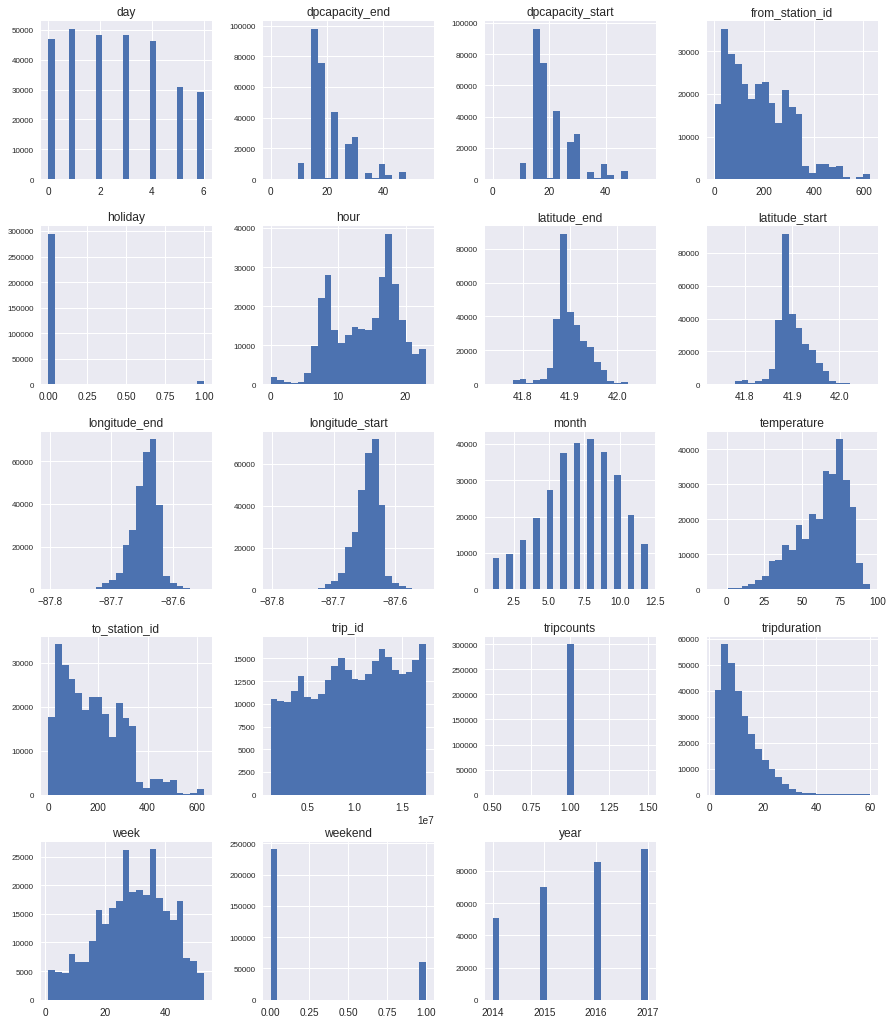

In [48]:
df.hist(figsize=(15, 18), bins=23, xlabelsize=10, ylabelsize=8)

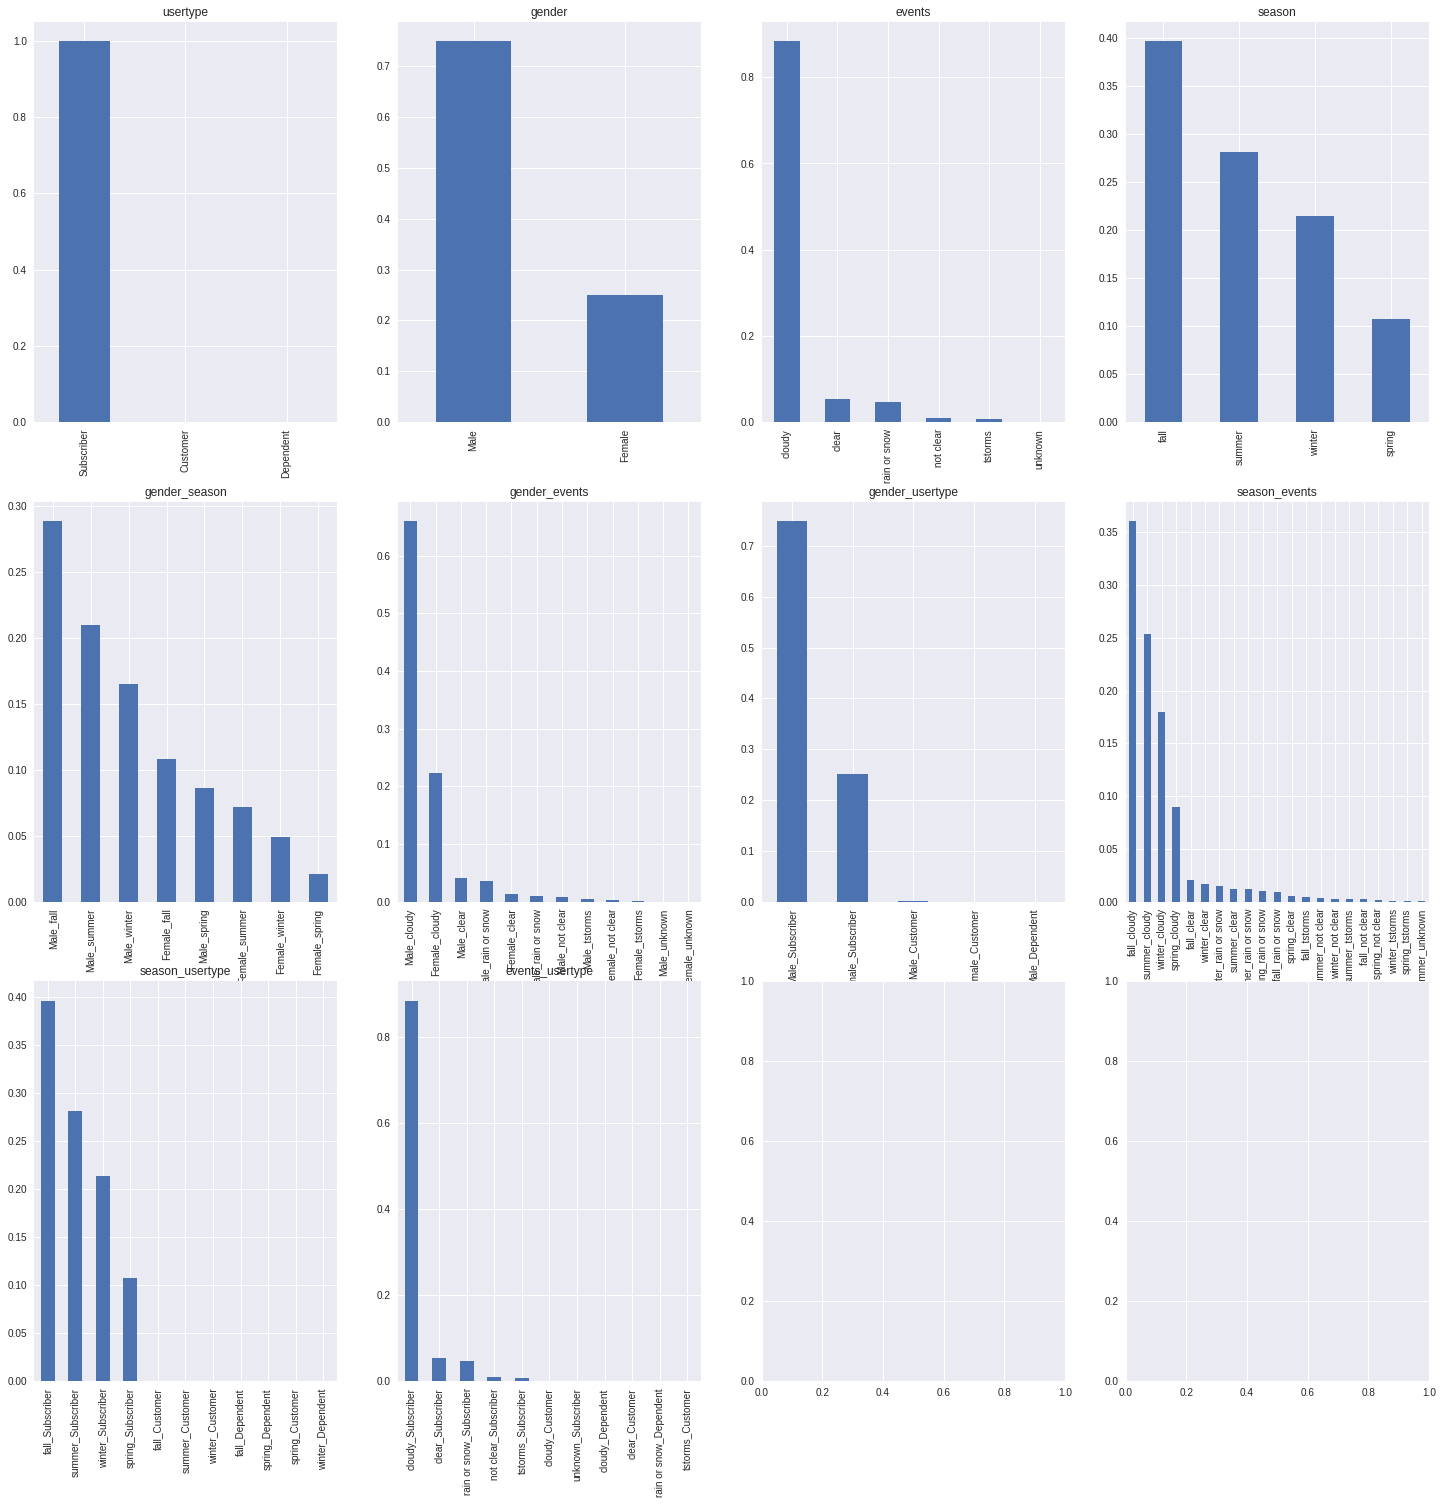

In [49]:
import matplotlib.pyplot as plt

# Plot histograms for categorical columns 
num = len(low_cardinal)
fig, axs = plt.subplots(3,4, figsize=(25, 25))
axs = axs.ravel()
for i, categorical_col in enumerate(low_cardinal):
    df_tmp = df[categorical_col].value_counts() / df.shape[0]
    df_tmp.plot(kind='bar', title = categorical_col, ax = axs[i])

Trip Length

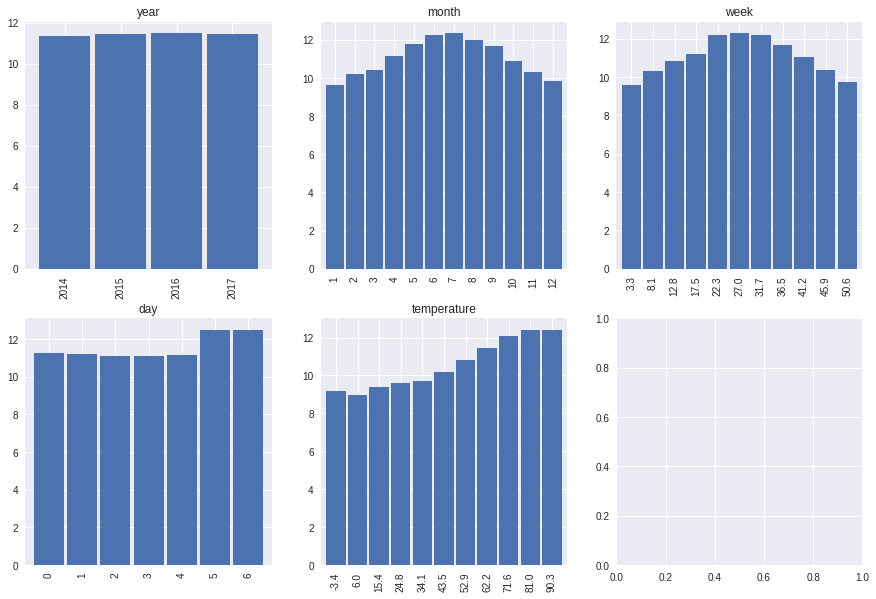

In [50]:
# Plot average for categorical columns 
fig, axs = plt.subplots(2,3, figsize=(15, 10))
axs = axs.ravel()
for i, categorical_col in enumerate(['year', 'month', 'week', 'day', 'temperature']):
    b = len(df[categorical_col].value_counts())
    if b > 50 :
        tmp = df.groupby(pd.cut(df[categorical_col], min(b, 11)))['tripduration'].mean().reset_index()
        tmp[categorical_col] = [np.round((a.left + a.right)/2,1) for a in tmp[categorical_col]]
    else:
        tmp = df.groupby([categorical_col])['tripduration'].mean().reset_index()
    tmp = tmp.set_index(categorical_col)
    del tmp.index.name
    tmp.plot(kind = 'bar', title = categorical_col, ax = axs[i], legend = False, width = 0.9)

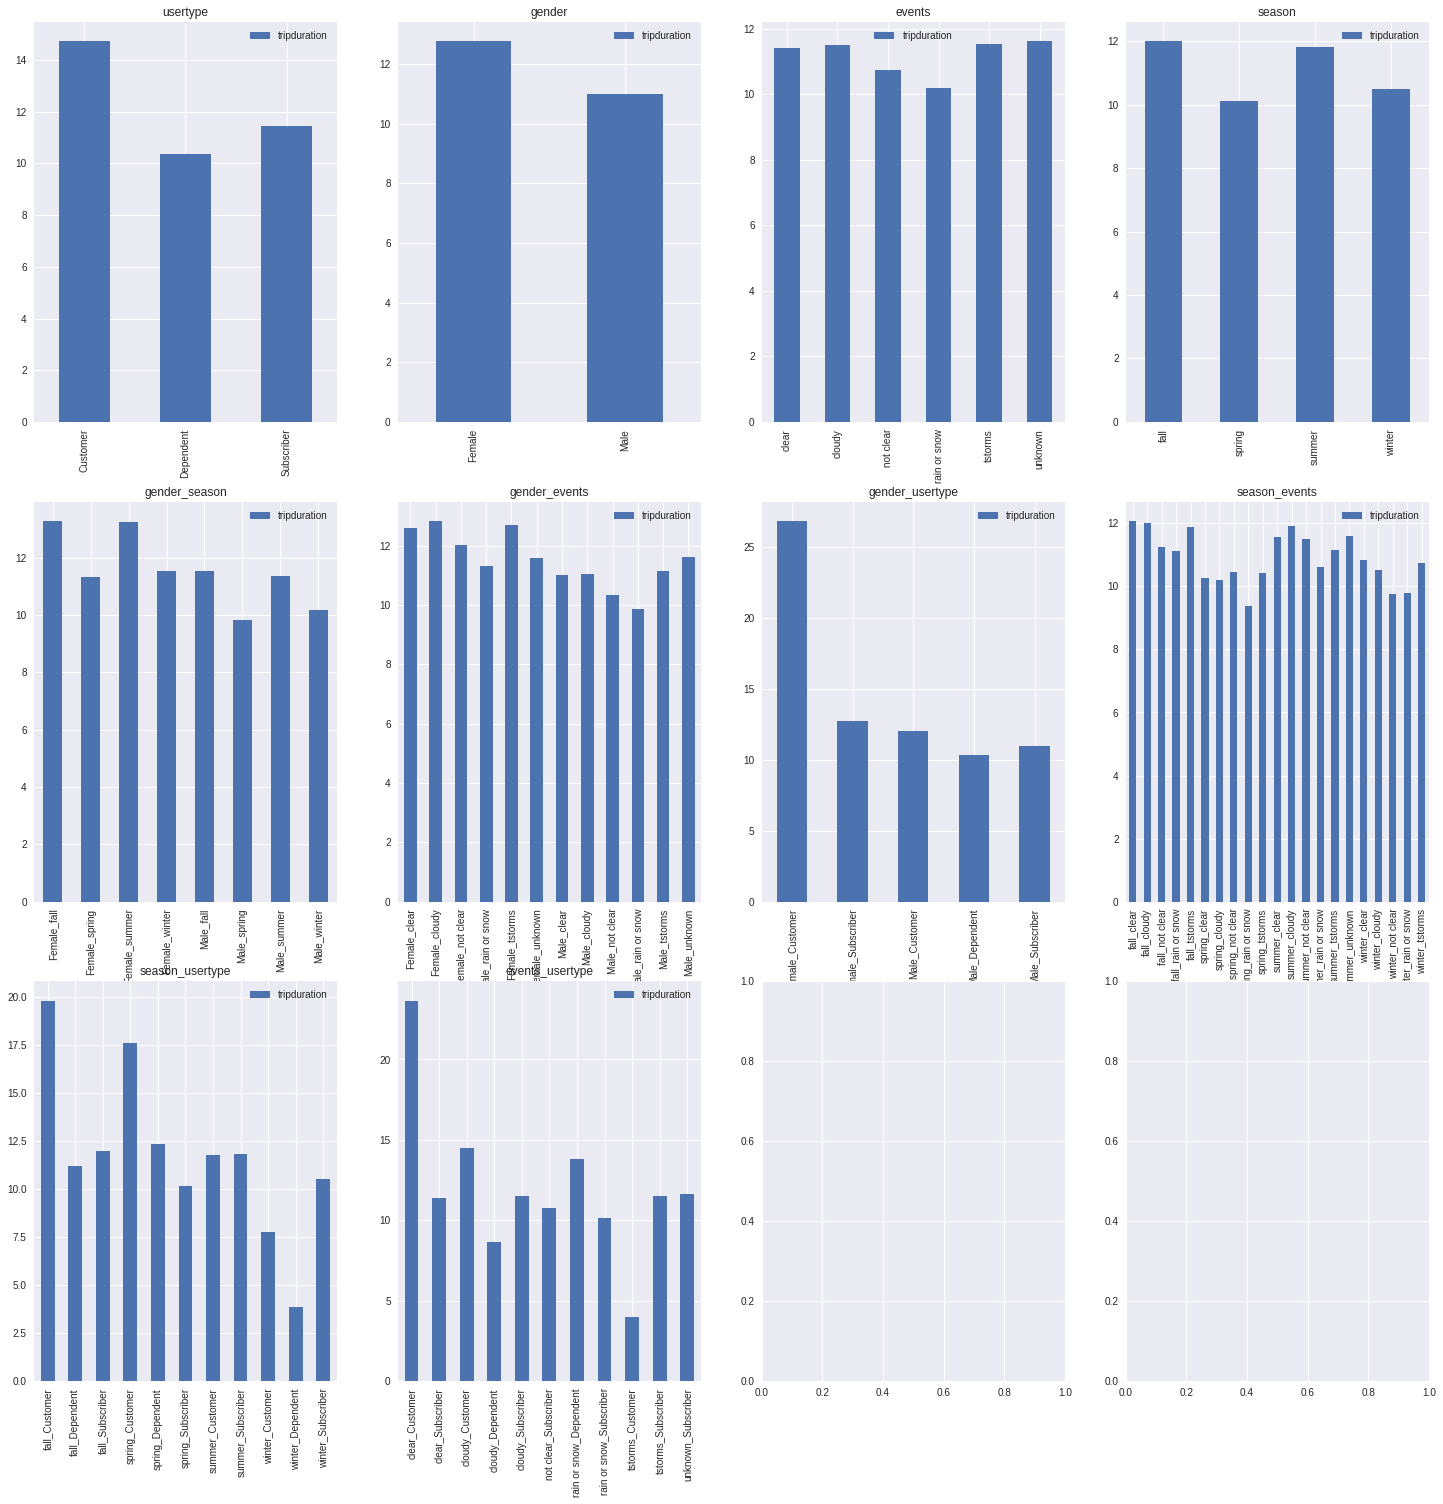

In [51]:
# Plot average for categorical columns 
num = len(low_cardinal)
fig, axs = plt.subplots(3,4, figsize=(25, 25))
axs = axs.ravel()
for i, categorical_col in enumerate(low_cardinal):
    tmp = df.groupby([categorical_col]).agg({'tripduration':np.mean})
    del tmp.index.name
    tmp.plot(kind='bar', ax = axs[i], title = categorical_col)

Feature Relationship

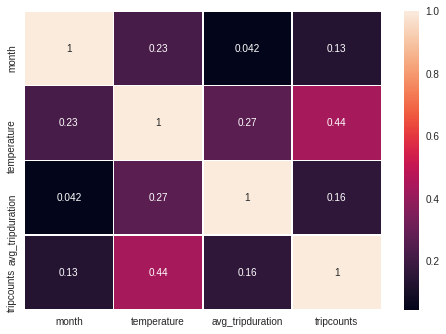

In [52]:
tmp = df_hour[['month', 'temperature', 'avg_tripduration', 'tripcounts']].corr()
sns.heatmap(tmp, xticklabels=tmp.columns,yticklabels=tmp.columns, annot= True, linewidths = 0.5);

Time Series Analysis

We decompose trend and seasonality

Trip Counts

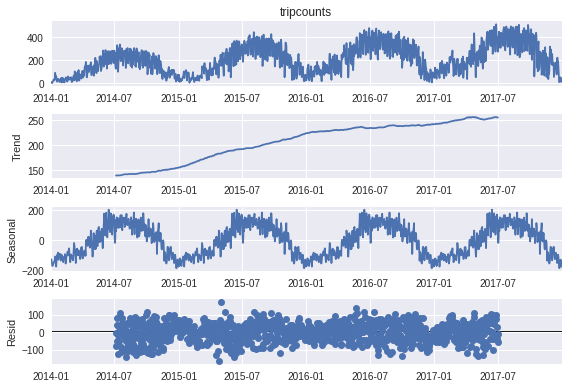

In [66]:
# Daily level
tc_counts = df_day.set_index('start_datetime')[['tripcounts']].tripcounts
tc_daily = sm.tsa.seasonal_decompose(tc_counts, period=365)
resplot = tc_daily.plot()

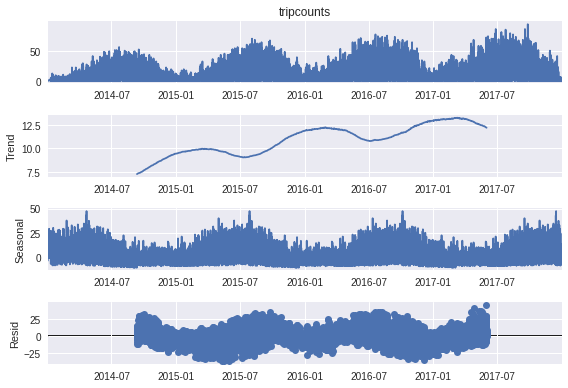

In [67]:
# Hourly level
tc_counts = df_hour.set_index('start_datetime')[['tripcounts']].tripcounts
tc_hourly = sm.tsa.seasonal_decompose(tc_counts, period=8760)
resplot = tc_hourly.plot()

Trip Lengths

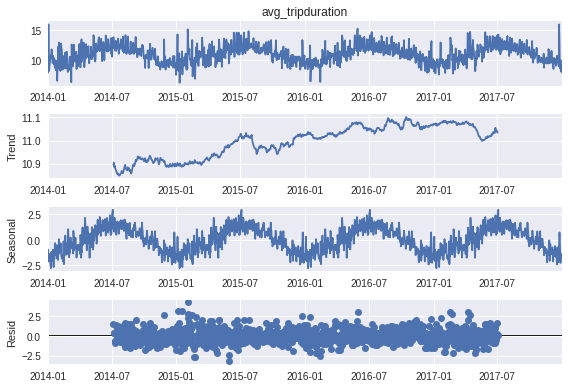

In [68]:
# Daily level
avg_dur = df_day.set_index('start_datetime')[['avg_tripduration']].avg_tripduration
dur_daily = sm.tsa.seasonal_decompose(avg_dur, period=365)
resplot = dur_daily.plot()

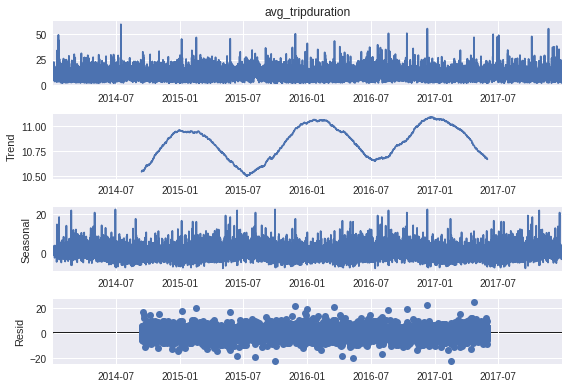

In [69]:
# Hourly level
avg_dur = df_hour.set_index('start_datetime')[['avg_tripduration']].avg_tripduration
dur_hourly = sm.tsa.seasonal_decompose(avg_dur, period=8760)
resplot = dur_hourly.plot()

Regression Analysis

We wil do regression analysis using both original df_hour, df_day and corresponding decompsed residue df for both tripcounts and avg_tripdurations. 
We will analysis coefficients and p-value for temperature.

In [70]:
df_hourly_regr = df_hour.drop(['startdate', 'tripduration'], axis = 1).reset_index(level=0)
df_daily_regr = df_day.drop(['startdate', 'tripduration'], axis = 1).reset_index(level=0)
df_hourly_regr.head()

,index,year,month,week,day,hour,temperature,events,tripcounts,avg_tripduration,weekend,holiday,season,start_datetime
0,0,2014,1,1,2,3,14.0,not clear,1,7.283333,0,1,spring,2014-01-01 03:00:00
1,1,2014,1,1,2,8,21.0,rain or snow,1,6.450000,0,1,spring,2014-01-01 08:00:00
2,2,2014,1,1,2,15,21.0,rain or snow,1,17.516667,0,1,spring,2014-01-01 15:00:00
3,3,2014,1,1,2,18,21.9,rain or snow,1,6.016667,0,1,spring,2014-01-01 18:00:00
4,4,2014,1,1,2,20,21.9,rain or snow,1,5.166667,0,1,spring,2014-01-01 20:00:00


In [72]:
df_daily_regr_resid.head()

,index,year,month,week,day,temperature,events,tripcounts,avg_tripduration,weekend,holiday,season,start_datetime,resid_x,resid_y
0,0,2014,1,1,2,20.133333,rain or snow,6,7.886111,0,1,spring,2014-01-01,NaN,NaN
1,1,2014,1,1,3,17.033333,rain or snow,3,16.016667,0,0,spring,2014-01-02,NaN,NaN
2,2,2014,1,1,5,30.333333,rain or snow,8,8.189583,1,0,spring,2014-01-04,NaN,NaN
3,3,2014,1,1,6,23.000000,rain or snow,2,9.083333,1,0,spring,2014-01-05,NaN,NaN
4,4,2014,1,2,3,18.492857,not clear,32,10.810937,0,0,spring,2014-01-09,NaN,NaN


In [73]:
df_daily_regr_resid = pd.merge(df_daily_regr, pd.DataFrame(dur_daily.resid).reset_index(), how = 'left', on = 'start_datetime')
df_daily_regr_resid = pd.merge(df_daily_regr_resid, pd.DataFrame(tc_daily.resid).reset_index(), how = 'left', on = 'start_datetime')

df_daily_regr_resid = df_daily_regr_resid[df_daily_regr_resid['resid_x'].notnull()]
df_daily_regr_resid = df_daily_regr_resid.drop(['index', 'year', 'month', 'week', 'day', 'tripcounts', 
                                                'avg_tripduration', 'weekend'], axis = 1)

df_hourly_regr_resid = pd.merge(df_hourly_regr, pd.DataFrame(dur_hourly.resid).reset_index(), how = 'left', on = 'start_datetime')
df_hourly_regr_resid = pd.merge(df_hourly_regr_resid, pd.DataFrame(tc_hourly.resid).reset_index(), how = 'left', on = 'start_datetime')

df_hourly_regr_resid = df_hourly_regr_resid[df_hourly_regr_resid['resid_x'].notnull()]
df_hourly_regr_resid = df_hourly_regr_resid.drop(['index', 'year', 'month', 'week', 'day',
                                                  'hour', 'tripcounts', 'avg_tripduration', 'weekend'], axis = 1)


df_hourly_regr_resid.head()

,temperature,events,holiday,season,start_datetime,resid_x,resid_y
4380,53.1,cloudy,0,fall,2014-09-11 14:00:00,0.159448,2.065153
4381,53.1,cloudy,0,fall,2014-09-11 15:00:00,-3.487770,4.731211
4382,52.0,cloudy,0,fall,2014-09-11 16:00:00,1.362880,11.397192
4383,51.1,cloudy,0,fall,2014-09-11 17:00:00,1.940202,15.062870
4384,51.1,cloudy,0,fall,2014-09-11 18:00:00,1.072455,14.062128


In [79]:
for col in ['year', 'month', 'week', 'day']:
    df_hourly_regr[col] = df_hourly_regr[col].astype(str)
    df_daily_regr[col] = df_daily_regr[col].astype(str)
df_hourly_regr['hour'] = df_hourly_regr['hour'].astype(str)

df_daily_regr = pd.get_dummies(df_daily_regr, prefix = ['year', 'month', 'week', 'day', 'events','season'])
df_hourly_regr = pd.get_dummies(df_hourly_regr, prefix = ['year', 'month', 'week', 'day', 'hour', 'events','season'])

df_daily_regr_resid = pd.get_dummies(df_daily_regr_resid, prefix = ['events','season'])
df_hourly_regr_resid = pd.get_dummies(df_hourly_regr_resid, prefix = ['events','season'])

In [80]:
weather_vars = ['temperature', 'events_clear', 'events_cloudy',
                'events_not clear', 'events_rain or snow', 'events_tstorms', 'events_unknown']

model_results = pd.DataFrame(columns = ['level', 'data_type', 'dependent_var', 'var', 'coef', 'pvalue'])

# Define function to append new results to dataframe
def add_to_results(m, level, d_type, d_var):
    out = model_results
    d = {}
    d['level'] = level
    d['data_type'] = d_type
    d['dependent_var'] = d_var
    for v in weather_vars:
        if v in model.params.index:
            d['var'] = v
            d['coef'] = m.params[v]
            d['pvalue'] = m.pvalues[v]
            out = out.append(d, ignore_index = True)
    return out

Trip Counts

Regression with raw data

In [86]:
# Daily Model - Raw data
X = df_daily_regr.drop(['avg_tripduration', 'tripcounts', 'start_datetime'], axis = 1)
Y = df_daily_regr['tripcounts']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model_results = add_to_results(model, 'daily', 'original', 'tripcounts')
model.summary()

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tripcounts   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     128.8
Date:                Thu, 23 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:11:54   Log-Likelihood:                -7555.9
No. Observations:                1456   AIC:                         1.527e+04
Df Residuals:                    1376   BIC:                         1.569e+04
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  81.0804     67.214      1.206      0.228     -50.772     212.933
index                  -0.1686      0.183     -0.923      0.356      -0.527       0.190
temperature             2.6097      0.137     19.005      0.000       2.340       2.879
weekend               -42.7215      8.042     -5.313      0.000     -58.496     -26.947
holiday               -58.5608      7.376     -7.940      0.000     -73.030     -44.092
year_2014            -130.1895     83.297     -1.563      0.118    -293.593      33.214
year_2015             -23.0964     16.948     -1.363      0.173     -56.343      10.150
year_2016              75.6722     50.185      1.508      0.132     -22.775     174.119
year_2017             158.6941    116.848      1.358      0.175     -70.525     387.913
month_1               -20.2699     13.331     -1.520      0.129     -46.422       5.882
month_10                4.8347     13.635      0.355      0.723     -21.912      31.582
month_11               -8.9172     15.022     -0.594      0.553     -38.386      20.552
month_12                8.6967     21.304      0.408      0.683     -33.096      50.489
month_2                -9.4961      9.388     -1.011      0.312     -27.913       8.921
month_3                 7.8576     12.866      0.611      0.541     -17.382      33.097
month_4               -21.4025     12.649     -1.692      0.091     -46.216       3.411
month_5                 0.6992     10.420      0.067      0.947     -19.742      21.140
month_6                56.6163     15.347      3.689      0.000      26.510      86.723
month_7                29.9555     12.532      2.390      0.017       5.371      54.540
month_8                33.0516     12.345      2.677      0.008       8.834      57.269
month_9                -0.5457     18.225     -0.030      0.976     -36.297      35.205
week_1                -10.6628     19.016     -0.561      0.575     -47.966      26.640
week_10               -31.3191     19.563     -1.601      0.110     -69.695       7.057
week_11               -37.8637     19.526     -1.939      0.053     -76.168       0.440
week_12               -35.8735     19.597     -1.831      0.067     -74.316       2.569
week_13               -40.2216     18.622     -2.160      0.031     -76.752      -3.691
week_14               -63.4409     18.825     -3.370      0.001    -100.369     -26.513
week_15               -46.3766     19.520     -2.376      0.018     -84.669      -8.084
week_16               -19.7755     19.562     -1.011      0.312     -58.150      18.599
week_17               -30.7343     19.431     -1.582      0.114     -68.853       7.384
week_18               -31.2133     18.032     -1.731      0.084     -66.587       4.161
week_19               -41.9861     19.521     -2.151      0.032     -80.279      -3.693
wee

In [87]:
# Hourly Model - Raw Data
X = df_hourly_regr.drop(['avg_tripduration', 'tripcounts', 'start_datetime'], axis = 1)
Y = df_hourly_regr['tripcounts']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model_results = add_to_results(model, 'hourly', 'original', 'tripcounts')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tripcounts   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     440.3
Date:                Thu, 23 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:13:07   Log-Likelihood:                -93515.
No. Observations:               28009   AIC:                         1.872e+05
Df Residuals:                   27905   BIC:                         1.881e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.0831      1.986      1.553      0.121      -0.809       6.975
index                  -0.0005      0.000     -1.839      0.066      -0.001    3.44e-05
temperature             0.1657      0.005     36.590      0.000       0.157       0.175
weekend                -2.2595      0.240     -9.425      0.000      -2.729      -1.790
holiday                -3.1929      0.274    -11.668      0.000      -3.729      -2.657
year_2014              -7.6276      2.510     -3.039      0.002     -12.548      -2.708
year_2015              -1.7627      0.594     -2.967      0.003      -2.927      -0.598
year_2016               3.8003      1.482      2.565      0.010       0.896       6.705
year_2017               8.6732      3.553      2.441      0.015       1.709      15.637
month_1                -1.2955      0.477     -2.714      0.007      -2.231      -0.360
month_10               -0.0482      0.446     -0.108      0.914      -0.922       0.825
month_11               -0.4360      0.476     -0.915      0.360      -1.369       0.498
month_12                0.6028      0.691      0.872      0.383      -0.752       1.958
month_2                -0.3962      0.357     -1.111      0.267      -1.095       0.303
month_3                 0.5684      0.465      1.224      0.221      -0.342       1.479
month_4                -0.8854      0.442     -2.003      0.045      -1.752      -0.019
month_5                 0.2241      0.350      0.640      0.522      -0.463       0.911
month_6                 2.4013      0.490      4.903      0.000       1.441       3.361
month_7                 1.1672      0.418      2.794      0.005       0.348       1.986
month_8                 1.4181      0.391      3.628      0.000       0.652       2.184
month_9                -0.2374      0.573     -0.414      0.679      -1.361       0.886
week_1                 -0.5112      0.709     -0.721      0.471      -1.900       0.878
week_10                -1.7560      0.710     -2.472      0.013      -3.148      -0.364
week_11                -2.2870      0.703     -3.253      0.001      -3.665      -0.909
week_12                -1.9051      0.702     -2.713      0.007      -3.281      -0.529
week_13                -2.1448      0.664     -3.231      0.001      -3.446      -0.844
week_14                -3.3813      0.669     -5.053      0.000      -4.693      -2.070
week_15                -2.6515      0.686     -3.863      0.000      -3.997      -1.306
week_16                -1.5136      0.686     -2.207      0.027      -2.858      -0.170
week_17                -1.7035      0.678     -2.511      0.012      -3.033      -0.374
week_18                -2.0104      0.626     -3.210      0.001      -3.238      -0.783
week_19                -2.4405      0.674     -3.623      0.000      -3.761      -1.120
wee

Regression with decomposed data

In [88]:
df_daily_regr_resid.head()

,temperature,holiday,start_datetime,resid_x,resid_y,events_clear,events_cloudy,events_not clear,events_rain or snow,season_fall,season_spring,season_summer,season_winter
182,78.844444,0,2014-07-06,1.491903,-77.248357,0,1,0,0,1,0,0,0
183,81.115789,0,2014-07-07,0.350311,-6.595389,0,1,0,0,1,0,0,0
184,75.023810,0,2014-07-08,0.391237,-52.589909,0,1,0,0,1,0,0,0
185,71.866667,0,2014-07-09,-0.715877,40.420136,0,1,0,0,1,0,0,0
186,70.495455,0,2014-07-10,-0.710118,79.717853,0,1,0,0,1,0,0,0


In [89]:
# Daily Model - Residuals data
X = df_daily_regr_resid.drop(['resid_x', 'resid_y', 'start_datetime'], axis = 1)
Y = df_daily_regr_resid['resid_y']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model_results = add_to_results(model, 'daily', 'residuals', 'tripcounts')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                resid_y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     10.97
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           5.80e-15
Time:                        20:15:03   Log-Likelihood:                -5808.4
No. Observations:                1092   AIC:                         1.163e+04
Df Residuals:                    1083   BIC:                         1.168e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -35.0854      7.556     -4.643      0.000     -49.912     -20.259
temperature             0.8599      0.129      6.654      0.000       0.606       1.114
holiday               -15.4113      8.946     -1.723      0.085     -32.964       2.141
events_clear            4.7075     10.403      0.452      0.651     -15.705      25.120
events_cloudy           0.3473      7.872      0.044      0.965     -15.098      15.793
events_not clear       -2.2284     27.947     -0.080      0.936     -57.066      52.609
events_rain or snow   -37.9117      9.179     -4.130      0.000     -55.921     -19.902
season_fall           -28.1925      4.751     -5.934      0.000     -37.515     -18.870
season_spring           9.8539      3.393      2.904      0.004       3.195      16.512
season_summer         -17.2266      3.770     -4.569      0.000     -24.624      -9.829
season_winter           0.4797      3.028      0.158      0.874      -5.462       6.422
==============================================================================
Omnibus:                       20.624   Durbin-Watson:                   1.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.383
Skew:                          -0.342   Prob(JB):                     2.27e-05
Kurtosis:                       3.052   Cond. No.                     5.29e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [90]:
# Hourly Model - Raw Data
X = df_hourly_regr_resid.drop(['resid_x', 'resid_y', 'start_datetime'], axis = 1)
Y = df_hourly_regr_resid['resid_y']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model_results = add_to_results(model, 'hourly', 'residuals', 'tripcounts')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                resid_y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     240.1
Date:                Thu, 23 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:15:29   Log-Likelihood:                -65796.
No. Observations:               19249   AIC:                         1.316e+05
Df Residuals:                   19238   BIC:                         1.317e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.2580      0.890     -5.906      0.000      -7.003      -3.513
temperature             0.1316      0.004     31.206      0.000       0.123       0.140
holiday                -1.5812      0.321     -4.919      0.000      -2.211      -0.951
events_clear           -1.6037      1.106     -1.450      0.147      -3.772       0.564
events_cloudy          -0.3822      1.095     -0.349      0.727      -2.529       1.765
events_not clear        0.5863      1.191      0.492      0.623      -1.748       2.921
events_rain or snow    -2.0178      1.104     -1.827      0.068      -4.182       0.147
events_tstorms         -3.4711      1.222     -2.840      0.005      -5.867      -1.075
events_unknown          1.6305      6.302      0.259      0.796     -10.721      13.982
season_fall            -1.6242      0.269     -6.043      0.000      -2.151      -1.097
season_spring          -1.5644      0.242     -6.478      0.000      -2.038      -1.091
season_summer          -1.5092      0.247     -6.108      0.000      -1.993      -1.025
season_winter          -0.5602      0.237     -2.364      0.018      -1.025      -0.096
==============================================================================
Omnibus:                      940.983   Durbin-Watson:                   0.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3439.007
Skew:                          -0.070   Prob(JB):                         0.00
Kurtosis:                       5.066   Cond. No.                     4.41e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.04e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Trip Lengths

Regression with raw data

In [92]:
# Daily Model - Raw Data
X = df_daily_regr.drop(['avg_tripduration', 'tripcounts', 'start_datetime'], axis = 1)
Y = df_daily_regr['avg_tripduration']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model_results = add_to_results(model, 'daily', 'original', 'avg_tripduration')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       avg_tripduration   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     29.24
Date:                Thu, 23 Apr 2020   Prob (F-statistic):          9.99e-239
Time:                        20:34:39   Log-Likelihood:                -1900.7
No. Observations:                1456   AIC:                             3961.
Df Residuals:                    1376   BIC:                             4384.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.6067      1.382      4.056      0.000       2.895       8.319
index                  -0.0034      0.004     -0.918      0.359      -0.011       0.004
temperature             0.0395      0.003     13.993      0.000       0.034       0.045
weekend                 1.1933      0.165      7.215      0.000       0.869       1.518
holiday                 0.5424      0.152      3.576      0.000       0.245       0.840
year_2014              -0.4890      1.713     -0.285      0.775      -3.850       2.872
year_2015               0.8172      0.349      2.344      0.019       0.133       1.501
year_2016               2.0193      1.032      1.956      0.051      -0.005       4.044
year_2017               3.2593      2.403      1.356      0.175      -1.455       7.974
month_1                 0.4712      0.274      1.718      0.086      -0.067       1.009
month_10                0.5971      0.280      2.129      0.033       0.047       1.147
month_11                0.6686      0.309      2.164      0.031       0.063       1.275
month_12                0.8554      0.438      1.952      0.051      -0.004       1.715
month_2                 0.2736      0.193      1.417      0.157      -0.105       0.652
month_3                -0.0396      0.265     -0.149      0.881      -0.559       0.480
month_4                -0.1630      0.260     -0.627      0.531      -0.673       0.347
month_5                 0.3723      0.214      1.737      0.083      -0.048       0.793
month_6                 0.6605      0.316      2.092      0.037       0.041       1.280
month_7                 0.4283      0.258      1.662      0.097      -0.077       0.934
month_8                 0.2594      0.254      1.022      0.307      -0.239       0.757
month_9                 1.2229      0.375      3.263      0.001       0.488       1.958
week_1                 -0.1267      0.391     -0.324      0.746      -0.894       0.641
week_10                 0.5673      0.402      1.410      0.159      -0.222       1.357
week_11                 1.2588      0.402      3.135      0.002       0.471       2.047
week_12                 0.8220      0.403      2.039      0.042       0.031       1.613
week_13                 0.6031      0.383      1.575      0.116      -0.148       1.354
week_14                 0.9718      0.387      2.510      0.012       0.212       1.731
week_15                 1.1512      0.401      2.868      0.004       0.364       1.939
week_16                 1.2456      0.402      3.096      0.002       0.456       2.035
week_17                 0.8277      0.400      2.071      0.039       0.044       1.612
week_18                 0.7748      0.371      2.089      0.037       0.047       1.502
week_19                 0.5143      0.401      1.281      0.200      -0.273       1.302
wee

In [93]:
# Hourly Model - Raw Data
X = df_hourly_regr.drop(['avg_tripduration', 'tripcounts', 'start_datetime'], axis = 1)
Y = df_hourly_regr['avg_tripduration']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model_results = add_to_results(model, 'hourly', 'original', 'avg_tripduration')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       avg_tripduration   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     29.00
Date:                Thu, 23 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:35:00   Log-Likelihood:                -76156.
No. Observations:               28009   AIC:                         1.525e+05
Df Residuals:                   27905   BIC:                         1.534e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.9900      1.068      0.927      0.354      -1.104       3.084
index                   0.0005      0.000      3.097      0.002       0.000       0.001
temperature             0.0398      0.002     16.347      0.000       0.035       0.045
weekend                 0.5550      0.129      4.303      0.000       0.302       0.808
holiday                 0.4168      0.147      2.831      0.005       0.128       0.705
year_2014               5.1664      1.351      3.825      0.000       2.519       7.814
year_2015               2.0834      0.320      6.517      0.000       1.457       2.710
year_2016              -1.3279      0.797     -1.666      0.096      -2.891       0.235
year_2017              -4.9319      1.912     -2.580      0.010      -8.679      -1.185
month_1                 0.7329      0.257      2.854      0.004       0.229       1.236
month_10                0.1588      0.240      0.662      0.508      -0.311       0.629
month_11               -0.0317      0.256     -0.124      0.902      -0.534       0.471
month_12               -0.3793      0.372     -1.020      0.308      -1.108       0.350
month_2                 0.3729      0.192      1.943      0.052      -0.003       0.749
month_3                -0.2351      0.250     -0.941      0.347      -0.725       0.255
month_4                 0.1447      0.238      0.608      0.543      -0.321       0.611
month_5                 0.1425      0.188      0.756      0.450      -0.227       0.512
month_6                -0.0686      0.264     -0.260      0.795      -0.585       0.448
month_7                 0.2302      0.225      1.024      0.306      -0.210       0.671
month_8                -0.2180      0.210     -1.037      0.300      -0.630       0.194
month_9                 0.1408      0.309      0.456      0.648      -0.464       0.745
week_1                 -0.1338      0.381     -0.351      0.726      -0.881       0.614
week_10                 0.5242      0.382      1.371      0.170      -0.225       1.273
week_11                 0.7353      0.378      1.944      0.052      -0.006       1.477
week_12                 0.4822      0.378      1.276      0.202      -0.258       1.223
week_13                 0.2810      0.357      0.787      0.432      -0.419       0.981
week_14                 0.7697      0.360      2.138      0.033       0.064       1.475
week_15                 0.8954      0.369      2.425      0.015       0.172       1.619
week_16                 0.6760      0.369      1.832      0.067      -0.047       1.399
week_17                 0.4966      0.365      1.360      0.174      -0.219       1.212
week_18                 0.4920      0.337      1.460      0.144      -0.168       1.152
week_19                 0.5050      0.362      1.393      0.163      -0.205       1.215
wee

Regression with decomposed data

In [94]:
# Daily Model - Residuals data
X = df_daily_regr_resid.drop(['resid_x', 'resid_y', 'start_datetime'], axis = 1)
Y = df_daily_regr_resid['resid_x']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model_results = add_to_results(model, 'daily', 'residuals', 'avg_tripduration')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                resid_x   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     6.910
Date:                Thu, 23 Apr 2020   Prob (F-statistic):           6.70e-09
Time:                        20:35:30   Log-Likelihood:                -1357.2
No. Observations:                1092   AIC:                             2732.
Df Residuals:                    1083   BIC:                             2777.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.5024      0.128     -3.917      0.000      -0.754      -0.251
temperature             0.0137      0.002      6.229      0.000       0.009       0.018
holiday                 0.2055      0.152      1.354      0.176      -0.092       0.503
events_clear           -0.0033      0.177     -0.018      0.985      -0.350       0.343
events_cloudy          -0.0720      0.134     -0.539      0.590      -0.334       0.190
events_not clear       -0.0037      0.474     -0.008      0.994      -0.934       0.927
events_rain or snow    -0.4234      0.156     -2.718      0.007      -0.729      -0.118
season_fall            -0.4121      0.081     -5.110      0.000      -0.570      -0.254
season_spring           0.1506      0.058      2.614      0.009       0.038       0.264
season_summer          -0.2456      0.064     -3.838      0.000      -0.371      -0.120
season_winter           0.0047      0.051      0.092      0.927      -0.096       0.106
==============================================================================
Omnibus:                       82.610   Durbin-Watson:                   1.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.003
Skew:                           0.494   Prob(JB):                     4.02e-36
Kurtosis:                       4.615   Cond. No.                     5.29e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [95]:
# Hourly Model - Raw Data
X = df_hourly_regr_resid.drop(['resid_x', 'resid_y', 'start_datetime'], axis = 1)
Y = df_hourly_regr_resid['resid_x']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model_results = add_to_results(model, 'hourly', 'residuals', 'avg_tripduration')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                resid_x   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     74.76
Date:                Thu, 23 Apr 2020   Prob (F-statistic):          3.86e-151
Time:                        20:35:51   Log-Likelihood:                -46827.
No. Observations:               19249   AIC:                         9.368e+04
Df Residuals:                   19238   BIC:                         9.376e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.9142      0.332     -2.751      0.006      -1.566      -0.263
temperature             0.0246      0.002     15.604      0.000       0.021       0.028
holiday                 0.0084      0.120      0.070      0.944      -0.227       0.244
events_clear           -0.1612      0.413     -0.390      0.696      -0.971       0.648
events_cloudy          -0.2102      0.409     -0.514      0.607      -1.012       0.591
events_not clear       -0.5046      0.445     -1.135      0.256      -1.376       0.367
events_rain or snow    -0.4772      0.412     -1.158      0.247      -1.285       0.331
events_tstorms         -0.5991      0.456     -1.313      0.189      -1.493       0.295
events_unknown          1.0381      2.352      0.441      0.659      -3.572       5.649
season_fall            -0.2107      0.100     -2.101      0.036      -0.407      -0.014
season_spring          -0.3439      0.090     -3.814      0.000      -0.521      -0.167
season_summer          -0.0964      0.092     -1.045      0.296      -0.277       0.084
season_winter          -0.2633      0.088     -2.977      0.003      -0.437      -0.090
==============================================================================
Omnibus:                     2161.632   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16154.060
Skew:                           0.274   Prob(JB):                         0.00
Kurtosis:                       7.454   Cond. No.                     4.41e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.04e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""